In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateparser import parse
from copy import deepcopy

In [2]:
import matplotlib.pyplot as plt

## Import and define useful functions

In [3]:
import os
os.chdir("../")

from pandemic_functions.delphi_functions.DELPHI_model_policy_scenarios import read_oxford_country_policy_data, read_policy_data_us_only, gamma_t
from pandemic_functions.pandemic_params import future_policies, policy_data_start_date, policy_data_end_date

/Users/saksham/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
default_dict_normalized_policy_gamma = {
    'No_Measure': 1.0,
    'Restrict_Mass_Gatherings': 0.873,
    'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.794,
    'Mass_Gatherings_Authorized_But_Others_Restricted': 0.668,
    'Restrict_Mass_Gatherings_and_Schools': 0.479,
    'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.423,
    'Lockdown': 0.239
}

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_inv(x):
    if x==1 or x==0:
        raise ZeroDivisionError
    # EPS = 1e-6
    return np.log(x/(1-x))

sigmoid_inv_np = np.vectorize(sigmoid_inv)

## Regional Gamma values for Policies

In [6]:
past_parameters = pd.read_csv("pandemic_functions/pandemic_data/Parameters_Global_V2_20200703.csv")
# past_parameters = pd.read_csv("pandemic_functions/pandemic_data/NY_Correction_Parameters_Global_V2_annealing_20210409.csv")

In [8]:
country = 'Spain'
province = 'None'


params_list = past_parameters.query("Country == @country and Province == @province")[
    ["Data Start Date", "Median Day of Action", "Rate of Action", "Jump Magnitude", "Jump Time", "Jump Decay"]
].iloc[0]
print(policy_data_start_date)
print(params_list['Data Start Date'])
final_start_date = max(parse(params_list['Data Start Date']), parse(policy_data_start_date))
final_start_date = str(final_start_date.date())
print(final_start_date)
# final_start_date = policy_data_start_date

if country == 'US':
    policy_data = read_policy_data_us_only(province, start_date=final_start_date, end_date=policy_data_end_date)
else:
    policy_data = read_oxford_country_policy_data(country=country, start_date=final_start_date, end_date=policy_data_end_date)

policy_data.loc[:, "Gamma"] = [
    gamma_t(day, params_list)
    for day in policy_data["date"]
]
n_measures = policy_data.iloc[:, 3:-1].shape[1]
dict_region_policy_gamma = {
    policy_data.columns[3 + i]: policy_data[
        policy_data.iloc[:, 3 + i] == 1
    ]
    .iloc[:, -1]
    .mean()
    for i in range(n_measures)
}
dict_region_policy_counts = {
    policy_data.columns[3 + i]: policy_data[
        policy_data.iloc[:, 3 + i] == 1
    ]
    .iloc[:, 3 + i]
    .sum()
    for i in range(n_measures)
}

2020-03-01
2020-03-02
2020-03-02


In [8]:
# policy_data = read_oxford_country_policy_data(country=country, start_date="2020-03-15", end_date="2020-6-15")

In [17]:
dict_region_policy_gamma

{'No_Measure': 1.3141371384043916,
 'Restrict_Mass_Gatherings': 2.127195524618138,
 'Mass_Gatherings_Authorized_But_Others_Restricted': nan,
 'Restrict_Mass_Gatherings_and_Schools': nan,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.9749908311265485,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.09265285387591703,
 'Lockdown': 0.18044320948200543}

In [9]:
default_dict_normalized_policy_gamma

{'No_Measure': 1.0,
 'Restrict_Mass_Gatherings': 0.873,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.794,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0.668,
 'Restrict_Mass_Gatherings_and_Schools': 0.479,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.423,
 'Lockdown': 0.239}

In [19]:
dict_region_policy_counts

{'No_Measure': 11,
 'Restrict_Mass_Gatherings': 4,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0,
 'Restrict_Mass_Gatherings_and_Schools': 0,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 2,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 68,
 'Lockdown': 68}

In [11]:
dict_region_policy_gamma = dict(sorted(dict_region_policy_gamma.items(), key=lambda x: x[0]))
dict_region_policy_counts = dict(sorted(dict_region_policy_counts.items(), key=lambda x: x[0]))
default_dict_normalized_policy_gamma = dict(sorted(default_dict_normalized_policy_gamma.items(), key=lambda x: x[0]))

In [12]:
from scipy.stats import linregress

x = np.array(list(default_dict_normalized_policy_gamma.values()))
y = np.array(list(dict_region_policy_gamma.values()))
ind = np.array(list(dict_region_policy_counts.values()))

train_keys = np.array(list(default_dict_normalized_policy_gamma.keys()))
train_keys = train_keys[(~np.isnan(y)) & (ind > 10)]

x_train = x[(~np.isnan(y)) & (ind > 10)]
y_train = y[(~np.isnan(y)) & (ind > 10)]
y_train = sigmoid_inv_np(y_train/2)

m, C, _, _, _ = linregress(x_train, y_train)

for key, val in dict_region_policy_gamma.items():
    if key not in train_keys:
        dict_region_policy_gamma[key] = 2*sigmoid(m*default_dict_normalized_policy_gamma[key] + C)
        # print(key, 2*sigmoid(m*default_dict_normalized_policy_gamma[key] + C))

In [13]:
key = 'Restrict_Mass_Gatherings_and_Schools_and_Others'
2*sigmoid(m*default_dict_normalized_policy_gamma[key] + C)

0.09265285387591704

In [14]:
train_keys

array(['Lockdown', 'Restrict_Mass_Gatherings_and_Schools_and_Others'],
      dtype='<U57')

In [ ]:
dict_region_policy_gamma

In [15]:
# sorted(dict_region_policy_gamma.items(), key=lambda x: x[1])
dict_region_policy_gamma

{'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.02277922864071226,
 'Lockdown': 0.18044320948200543,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0.03687044282187609,
 'No_Measure': 0.010310141347597144,
 'Restrict_Mass_Gatherings': 0.016817903517856895,
 'Restrict_Mass_Gatherings_and_Schools': 0.07524425216299054,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.09265285387591703}

In [ ]:
{'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.02277922864071226, 
'Lockdown': 0.18044320948200543, 
'Mass_Gatherings_Authorized_But_Others_Restricted': 0.03687044282187609, 
'No_Measure': 0.010310141347597144, 
'Restrict_Mass_Gatherings': 0.016817903517856895, 
'Restrict_Mass_Gatherings_and_Schools': 0.07524425216299054, 
'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.09265285387591703}

{'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.7950475216464683, 
'Lockdown': 0.18044320948200543, 
'Mass_Gatherings_Authorized_But_Others_Restricted': 0.551618671754817, 
'No_Measure': 1.3141371384043916, 
'Restrict_Mass_Gatherings': 0.9643982865949828, 
'Restrict_Mass_Gatherings_and_Schools': 0.28622589661462394, 
'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.12279766308608538}

In [18]:
train_keys

array(['Lockdown', 'Restrict_Mass_Gatherings_and_Schools_and_Others'],
      dtype='<U57')

In [19]:
dict_region_policy_gamma

{'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.054987436444905176,
 'Lockdown': 0.18044320948200543,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0.07245735485494019,
 'No_Measure': 0.034868386080552545,
 'Restrict_Mass_Gatherings': 0.046199770815040696,
 'Restrict_Mass_Gatherings_and_Schools': 0.10898804969292702,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.12279766308608538}

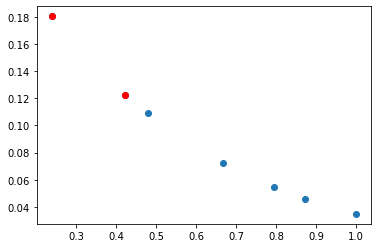

In [20]:
y = np.array(list(dict_region_policy_gamma.values()))
plt.scatter(x, 2*sigmoid(x*m + C))
plt.scatter(x_train, 2*sigmoid(y_train), color='red')

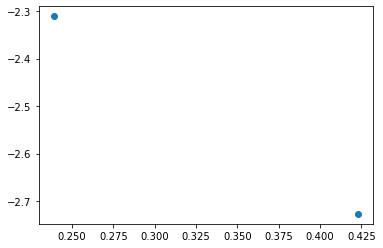

In [18]:
plt.scatter(x_train, y_train)

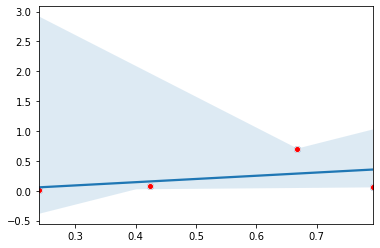

In [9]:
import seaborn as sns
g = sns.regplot(x_train, y_train)
sns.scatterplot(x, y, color='red')

In [15]:
past_parameters.query("Country == @country")

,Continent,Country,Province,Data Start Date,MAPE,Infection Rate,Median Day of Action,Rate of Action,Rate of Death,Mortality Rate,Rate of Mortality Rate Decay,Internal Parameter 1,Internal Parameter 2,Jump Magnitude,Jump Time,Jump Decay
65,Europe,Germany,None,2020-03-01,56.100635,2.714868,5.044104,4.431403,0.071761,0.049394,0.01232,2.707296,0.477221,3.03437,98.536701,1.016234


## Gamma values for different policies internationally

In [5]:
from pandemic_functions.delphi_functions.DELPHI_model_policy_scenarios import gamma_t

In [6]:
policy_data_countries = read_oxford_international_policy_data("2020-06-01")
policy_data_countries.loc[:,"country_cl"] = policy_data_countries["country"].apply(
    lambda x: x.replace(",", "").strip().lower()
)
countries_set = set(policy_data_countries["country_cl"])

past_parameters_copy = deepcopy(past_parameters)
past_parameters_copy.loc[:, "Country"] = past_parameters_copy["Country"].apply(
    lambda x: str(x).replace(",", "").strip().lower()
)
params_countries = past_parameters_copy["Country"]
params_countries = set(params_countries)
policy_data_countries_bis = policy_data_countries.query(
    "country_cl in @params_countries"
)

params_dic = {}
countries_set = countries_set.intersection(params_countries)
for country in countries_set:
    params_dic[country] = past_parameters_copy.query("Country == @country")[
        ["Data Start Date", "Median Day of Action", "Rate of Action"]
    ].iloc[0]

policy_data_countries_bis.loc[:,"Gamma"] = [
    gamma_t(day, country, params_dic)
    for day, country in zip(
        policy_data_countries_bis["date"], policy_data_countries_bis["country_cl"]
    )
]
n_measures = policy_data_countries_bis.iloc[:, 3:-2].shape[1]
dict_normalized_policy_gamma = {
    policy_data_countries_bis.columns[3 + i]: policy_data_countries_bis[
        policy_data_countries_bis.iloc[:, 3 + i] == 1
    ]
    .iloc[:, -1]
    .mean()
    for i in range(n_measures)
}

/Users/saksham/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/saksham/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/saksham/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [7]:
dict_normalized_policy_gamma

{'No_Measure': 1.224290866083324,
 'Restrict_Mass_Gatherings': 0.9212492614815385,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 1.1939111331532786,
 'Restrict_Mass_Gatherings_and_Schools': 1.8554005264375264,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.7891718671910969,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.6950541388557803,
 'Lockdown': 0.7060714502148392}

## Interpolate Gamma values

In [10]:
default_dict_normalized_policy_gamma

{'No_Measure': 1.0,
 'Restrict_Mass_Gatherings': 0.8104706755038068,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0.7958070876891542,
 'Restrict_Mass_Gatherings_and_Schools': 0.22248206249986824,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.02076684601453382,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.09063592219879021,
 'Lockdown': 0.011073174927134189}

In [11]:
from scipy.stats import linregress

x = np.array(list(default_dict_normalized_policy_gamma.values()))
y = np.array(list(dict_normalized_policy_gamma_country.values()))

x_train, x_test = x[~np.isnan(y)], x[np.isnan(y)]
y_train = y[~np.isnan(y)]

m, C, _, _, _ = linregress(x_train, y_train)

for key, val in dict_normalized_policy_gamma_country.items():
    if np.isnan(dict_normalized_policy_gamma_country[key]):
        dict_normalized_policy_gamma_country[key] = m*default_dict_normalized_policy_gamma[key] + C

dict_normalized_policy_gamma_country

{'No_Measure': 0.882873941367236,
 'Restrict_Mass_Gatherings': 0.718050896592993,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0.7061835256280393,
 'Restrict_Mass_Gatherings_and_Schools': 0.20671011201778164,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.05506083991833012,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.08042853108125524,
 'Lockdown': 0.009826117197129107}

Above values are un-normalized

In [12]:
m, C

(0.8696440258644705, 0.013229915502765477)

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(x, y)

NameError: name 'x' is not defined

In [14]:
normalize_val = dict_normalized_policy_gamma_country[future_policies[0]]
for policy in dict_normalized_policy_gamma_country.keys():
    dict_normalized_policy_gamma_country[policy] = (
        dict_normalized_policy_gamma_country[policy] / normalize_val
    )
dict_normalized_policy_gamma_country

{'No_Measure': 1.0,
 'Restrict_Mass_Gatherings': 0.813310783055852,
 'Mass_Gatherings_Authorized_But_Others_Restricted': 0.79986903287057,
 'Restrict_Mass_Gatherings_and_Schools': 0.2341332123787302,
 'Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others': 0.0623654605017131,
 'Restrict_Mass_Gatherings_and_Schools_and_Others': 0.09109854455178734,
 'Lockdown': 0.011129694440762618}

## Debugging and analysis

In [21]:
from pandemic_functions.delphi_functions.DELPHI_model_policy_scenarios import get_latest_policy
from dateutil.relativedelta import relativedelta

In [24]:
 start = pd.to_datetime("2020-04-01")
 for i in range(0,3):
    print(i, get_latest_policy(policy_data, start+relativedelta(months=i)))

0 Restrict_Mass_Gatherings_and_Schools_and_Others
1 Restrict_Mass_Gatherings_and_Schools_and_Others
2 Authorize_Schools_but_Restrict_Mass_Gatherings_and_Others


In [6]:
past_parameters.query("Province == 'New York'")

,Continent,Country,Province,Data Start Date,MAPE,Infection Rate,Median Day of Action,Rate of Action,Rate of Death,Mortality Rate,Rate of Mortality Rate Decay,Internal Parameter 1,Internal Parameter 2,Jump Magnitude,Jump Time,Jump Decay
190,North America,US,New York,2020-03-08,84.528473,10.088795,0.15692,12.093626,0.479893,0.088566,0.063241,4.892041,1.075604,0.927178,104.162591,1.104433


In [7]:
past_parameters["Infection Rate"].mean()

2.492015619455979